In [1]:
%matplotlib inline

import os
from glob import glob
import pickle

import numpy as np
import pandas as pd
import math

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.applications.densenet import DenseNet121
from itertools import cycle
from tensorflow.keras.metrics import MeanIoU
from tqdm import tqdm

## Setting

In [2]:
#from PIL import Image
from tf_keras_vis.utils import num_of_gpus

# !pip install keras-vis
# !pip install tf-keras-vis

%reload_ext autoreload
%autoreload 2
%matplotlib inline

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 1 GPUs


In [3]:
#from tf_keras_vis.utils import num_of_gpus
import collections
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
#from sklearn.model_selection import train_test_split
import matplotlib as mpl
#import matplotlib.pyplot as plt
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Conv1D,Conv2D, Flatten
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, Dropout, BatchNormalization, Activation, Add, Flatten, Dense)
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

In [4]:
# Check path
my_path = os.getcwd()
my_dir = '/home/ubuntu/Kyulee/ECG_2210/'
train_dir = '/home/ubuntu/dr-you-ecg-20220420_mount/STEMI_JKL/221028_STEMI/'
My_dir = '/home/ubuntu/dr-you-ecg-20220420_mount/STEMI_JKL/2023_Jan_testset/'
print('work_path: {}\ndata_directory: {}'.format(my_path, my_dir))

work_path: /home/ubuntu/Kyulee/ECG_2301
data_directory: /home/ubuntu/Kyulee/ECG_2210/


# 1. Data Load

In [5]:
# load dataset
X_test, Y_test = np.load(My_dir+'x_pain_0113.npy'), np.load(My_dir+'y_pain_0113.npy')
print('X_test {}, Y_test {}'.format(X_test.shape, Y_test.shape))

X_test (2765, 5000, 8), Y_test (2765,)


In [6]:
# Check dataset proportion
counter_test = collections.Counter(Y_test)

def proportion(counters):
    for i, counter in enumerate(counters):
        name = ['ED chest pain'][i]
        neg, pos = counter[0], counter[1]
        total = neg + pos
        print('{} Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n    Negative: {} ({:.2f}% of total)\n'.format(
            name, total, pos, 100 * pos / total, neg, 100 * neg / total))
proportion([counter_test])

ED chest pain Examples:
    Total: 2765
    Positive: 102 (3.69% of total)
    Negative: 2663 (96.31% of total)



In [7]:
# Transform dataset to categorical (one-hot encoding)
y_test = tf.keras.utils.to_categorical(Y_test)
print('y_test {}'.format(y_test.shape))

y_test (2765, 2)


# 2. Modeling

In [8]:
# Load saved model
sing_model = keras.models.load_model(my_dir+'ami_model/0_model-best.h5')

In [9]:
# Load saved model
nets = 5
de_model = [0]*5
for i in [0,1,2,3,4]:
    de_model[i] = keras.models.load_model(my_dir+'ami_model/BestModelSaved/221204_1643'+str(i+1)+'_bestmodel.h5')

# 3. Test

## 3.0. Methods

In [10]:
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, recall_score, f1_score, balanced_accuracy_score, classification_report, roc_curve, precision_score

In [11]:
# confusion matrix
def matrix(y_true, y_pred, y_proba):
    conf_mat = confusion_matrix(y_true[:,1], y_pred[:,1])
    TP = conf_mat[1][1]
    TN = conf_mat[0][0]
    FN = conf_mat[1][0]
    FP = conf_mat[0][1]

    acc = round((TP+TN)/(TP+TN+FP+FN), 4)
    sens = round(TP/(TP+FN), 4)
    spec = round(TN/(TN+FP), 4)
    ppv = round(TP/ (TP+FP), 4)
    npv = round(TN/ (TN+FN), 4)
    auroc = round(roc_auc_score(y_true, y_proba), 4)
    precision = round(precision_score(y_true.argmax(axis=1), y_pred.argmax(axis=1)), 4)
    recall = round(recall_score(y_true.argmax(axis=1), y_pred.argmax(axis=1)), 4)
    f1score = round(f1_score(y_true.argmax(axis=1), y_pred.argmax(axis=1)), 4)
    ap = round(average_precision_score(y_true, y_pred), 4)

    print(conf_mat, "\n")
    print("Accuracy", acc)
    print("Sensitivity", sens)
    print("Specificity", spec)
    print("PPV", ppv)
    print("NPV", npv)
    print("AUROC", auroc)
    print("Average Precision", ap)
    print('Precision', precision)
    print("Recall", recall)
    print("F1",  f1score)
    
    # ROC & AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(y_true.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    colors = cycle(['blue', 'red'])
    for i, color in zip(range(y_true.shape[1]), colors):
        if i == 0:
            pass
        else:
            plt.plot(fpr[i], tpr[i], color=color, lw=1.5, label='ROC curve (area = {0:0.2f})' ''.format(roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], lw=1.5, color='black', linestyle='dotted', label = 'baseline')
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

label = {'0': 'Not-STEMI', '1':'STEMI'}

In [12]:
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score

def prc(y_true, y_pred, y_proba):
    # PR & AUC
    prec = dict()
    rec = dict()
    pr_auc = dict()
    for i in range(y_true.shape[1]):
        prec[i], rec[i], _ = sklearn.metrics.precision_recall_curve(y_true[:,i], y_proba[:, i])
        pr_display = sklearn.metrics.PrecisionRecallDisplay(precision=prec[i], recall=rec[i])
    pr_display.plot(label = 'Precision-Recall curve (area = {0:0.2f})' ''.format(average_precision_score(y_true, y_pred)))
    plt.show()

label = {'0': 'Non-STEMI', '1':'STEMI'}

In [13]:
def plot_cm(labels, predictions, p):
    cf_matrix = confusion_matrix(labels, predictions > p)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages_pos = ["({0:.2%})".format(value) for value in cf_matrix.flatten()[0:2]/np.sum(cf_matrix.flatten()[0:2])]
    group_percentages_neg = ["({0:.2%})".format(value) for value in cf_matrix.flatten()[2:4]/np.sum(cf_matrix.flatten()[2:4])]
    group_percentages = group_percentages_pos + group_percentages_neg
    categories = ['Not-STEMI', 'STEMI']
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    #plt.figure(figsize=(5,5))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',xticklabels=categories,yticklabels=categories, annot_kws={"size": 12})
    plt.title('Confusion Matrix (cut off = {:.2f})'.format(p), fontsize= 14)
    plt.ylabel('Actual label', fontsize= 12)
    plt.xlabel('Predicted label', fontsize= 12)

In [21]:
# deep ensemble model TEST
def test_demodel(de_model, x_dataset):
    each_proba = []
    for m in de_model:
        proba = m.predict(x_dataset)
        each_proba.append(proba)
    results = np.zeros( (x_dataset.shape[0],2) )
    for p in each_proba:
        results += p
    de_proba = results / len(de_model)
    return de_proba

In [14]:
def result_report(y_test, y_pred, y_proba, threshold):
    print(matrix(y_test, y_pred, y_proba))
    print(prc(y_test, y_pred, y_proba))
    print(plot_cm(y_test[:,1], y_pred[:,1], threshold))

In [15]:
import sklearn
from sklearn.calibration import calibration_curve
def calibration_plot(true, probs, n_bins):
    # reliability diagram
    prob_true, prob_pred = calibration_curve(true[:,1], probs[:,1], n_bins=n_bins)

    # plot perfectly calibrated
    plt.plot([0,1], [0,1], linestyle='--')

    # plot model reliability
    plt.plot(prob_pred, prob_true, marker='.')
    plt.title('Calibration Plot (bins: {0:d})' ''.format(n_bins))
    plt.show()

## 3.1. Single Model

In [16]:
sval_yi = 0.0143
dval_yi = 0.0768

In [17]:
sing_proba = sing_model.predict(X_test)

[[2399  264]
 [   6   96]] 

Accuracy 0.9024
Sensitivity 0.9412
Specificity 0.9009
PPV 0.2667
NPV 0.9975
AUROC 0.9728
Average Precision 0.6214
Precision 0.7895
Recall 0.7353
F1 0.7614


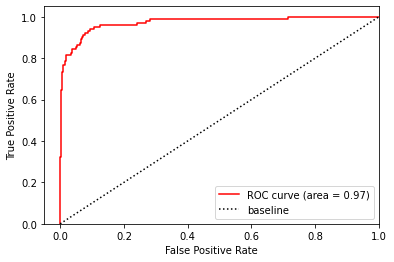

None


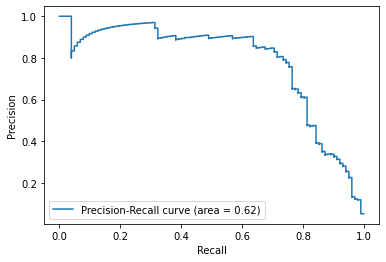

None
None


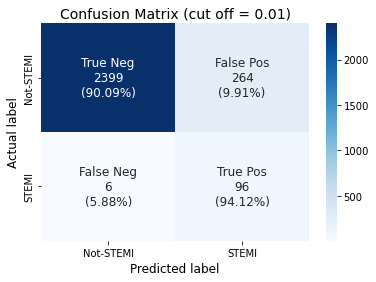

In [18]:
sing_pred = (sing_proba > sval_yi).astype(np.int64)
result_report(y_test, sing_pred, sing_proba, sval_yi)

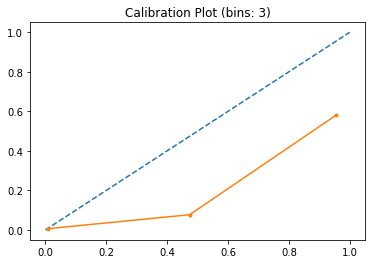

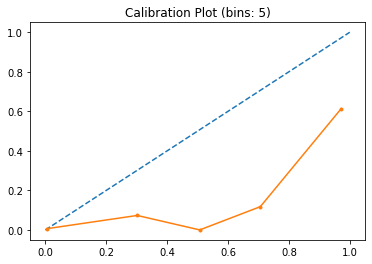

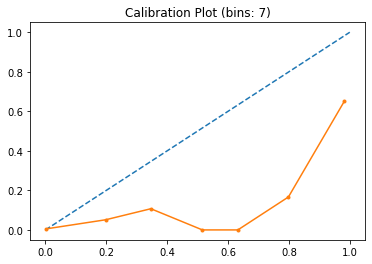

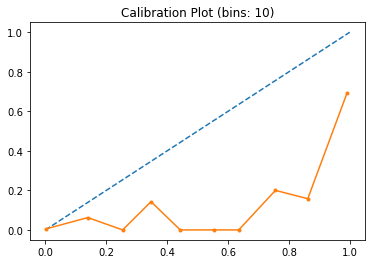

In [19]:
for i in [3, 5, 7, 10]:
    calibration_plot(y_test, sing_proba, i)

## 4.2. Deep Ensemble

In [29]:
for m in de_model:
    loss = m.evaluate(X_test, y_test)
    print(loss)

42/42 [==============================] - 1s 12ms/step - loss: 0.1237 - accuracy: 0.9651 - prc: 0.9890
[0.12365199625492096, 0.9651250839233398, 0.9889984726905823]
42/42 [==============================] - 1s 10ms/step - loss: 0.0983 - accuracy: 0.9704 - prc: 0.9914
[0.09825931489467621, 0.9704321622848511, 0.9914310574531555]
42/42 [==============================] - 1s 10ms/step - loss: 0.1064 - accuracy: 0.9651 - prc: 0.9884
[0.10635349154472351, 0.9651250839233398, 0.9884479641914368]
42/42 [==============================] - 1s 10ms/step - loss: 0.0932 - accuracy: 0.9651 - prc: 0.9938
[0.09322711080312729, 0.9651250839233398, 0.9937710165977478]
42/42 [==============================] - 1s 10ms/step - loss: 0.1172 - accuracy: 0.9621 - prc: 0.9855
[0.11724250763654709, 0.9620925188064575, 0.9855208396911621]


In [22]:
de_proba = test_demodel(de_model, X_test)

[[2335  328]
 [   5   97]] 

Accuracy 0.8796
Sensitivity 0.951
Specificity 0.8768
PPV 0.2282
NPV 0.9979
AUROC 0.9764
Average Precision 0.6009
Precision 0.9032
Recall 0.549
F1 0.6829


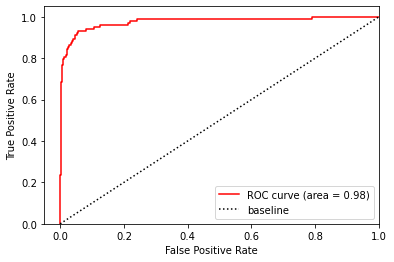

None


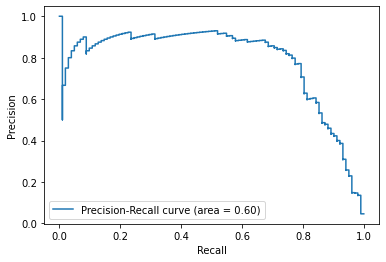

None
None


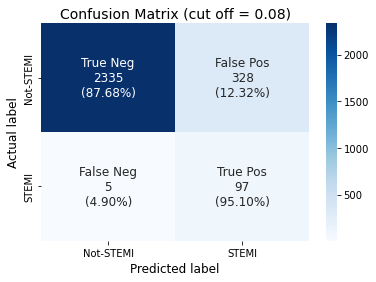

In [24]:
de_pred = (de_proba > dval_yi).astype(np.int64)
result_report(y_test, de_pred, de_proba, dval_yi)

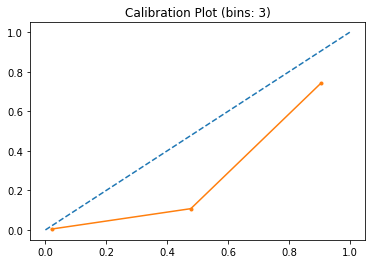

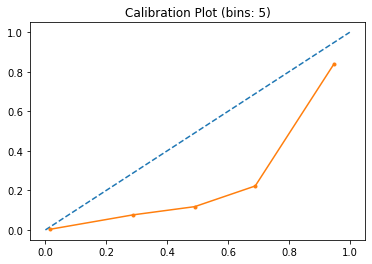

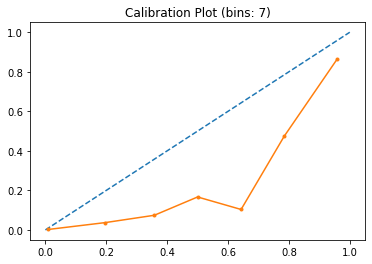

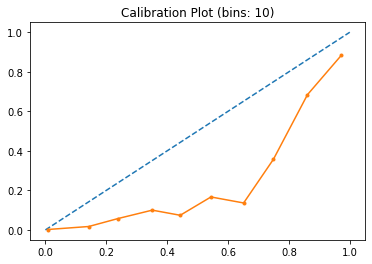

In [25]:
for i in [3, 5, 7, 10]:
    calibration_plot(y_test, de_proba, i)

# 6. Uncertainty (Entropy) Estimation

In [32]:
co_15 = 0.1788
sco_15 = 0.0063

In [26]:
def uc_grouping(entropy_list, cutoff):
    high_idx = []
    low_idx = []
    for idx, entropy in enumerate(entropy_list):
        if entropy >= cutoff:
            high_idx.append(idx)
        else:
            low_idx.append(idx)
            
    return high_idx, low_idx

In [27]:
def high_uncertainty(entropy_list, y_true, y_proba, y_pred, cutoff, threshold):
    high, low = uc_grouping(entropy_list, cutoff=cutoff)
    true_high = y_true[high]
    pred_high = y_pred[high]
    proba_high = y_proba[high]
    print("Uncertainty High: %.2f%%" % (len(high) / len(entropy_list) * 100.0)), print(result_report(true_high, pred_high, proba_high, threshold))

def low_uncertainty(entropy_list, y_true, y_proba, y_pred, cutoff, threshold):
    high, low = uc_grouping(entropy_list, cutoff=cutoff)
    true_low = y_true[low]
    pred_low = y_pred[low]
    proba_low = y_proba[low]
    print("Uncertainty Low: %.2f%%" % (len(low) / len(entropy_list) * 100.0)), print(result_report(true_low, pred_low, proba_low, threshold))

In [28]:
# Deep Ensembles
de_entropy_list = []
for i in range(len(de_proba)):
    pq = de_proba[i] * y_test[i] #정답에 대한 예측 확률 사용하는거 맞는지 확인
    index = np.argmax(pq)
    p = pq[index]
    entropy = -p*math.log(p) - (1-p)*math.log(1-p+ 0.00000000001)
    de_entropy_list.append(entropy)

In [29]:
# Single 
sing_entropy_list = []
for i in range(len(sing_proba)):
    pq = sing_proba[i] * y_test[i] #정답에 대한 예측 확률 사용하는거 맞는지 확인
    index = np.argmax(pq)
    p = pq[index]
    entropy = -p*math.log(p) - (1-p)*math.log(1-p+ 0.00000000001)
    sing_entropy_list.append(entropy)

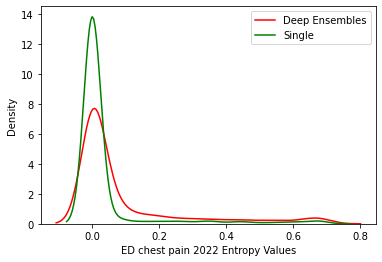

In [31]:
# plot distribution
sns.kdeplot(de_entropy_list, label='Deep Ensembles', color='r')
sns.kdeplot(sing_entropy_list, label='Single', color='g')
plt.xlabel('ED chest pain 2022 Entropy Values')
plt.legend()
plt.show()

## 5.3. Divide Groups and Check Each Group's Results

#### 5.3.1. Single Net

Uncertainty High: 15.66%
[[130 258]
 [  2  43]] 

Accuracy 0.3995
Sensitivity 0.9556
Specificity 0.3351
PPV 0.1429
NPV 0.9848
AUROC 0.828
Average Precision 0.5408
Precision 0.6111
Recall 0.4889
F1 0.5432


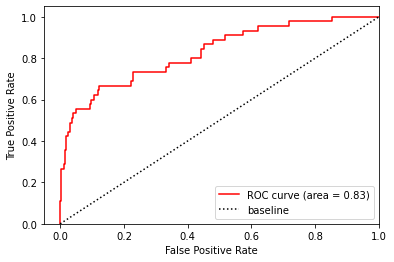

None


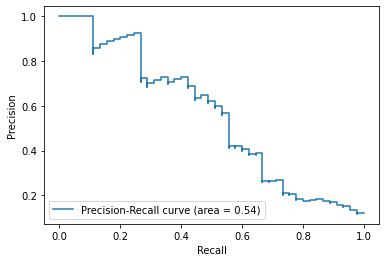

None
None
None


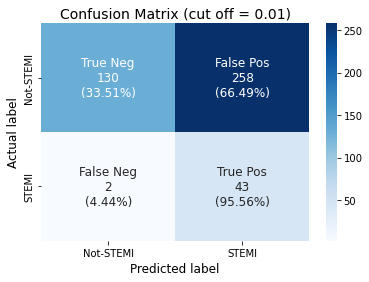

In [33]:
high_uncertainty(sing_entropy_list, y_test, sing_proba, sing_pred, sco_15, sval_yi)

Uncertainty Low: 84.34%
[[2269    6]
 [   4   53]] 

Accuracy 0.9957
Sensitivity 0.9298
Specificity 0.9974
PPV 0.8983
NPV 0.9982
AUROC 0.9802
Average Precision 0.9176
Precision 0.8983
Recall 0.9298
F1 0.9138


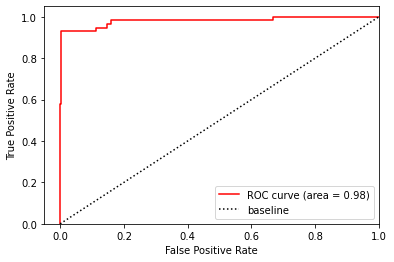

None


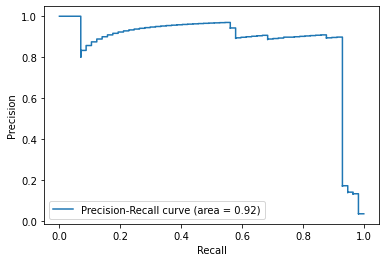

None
None
None


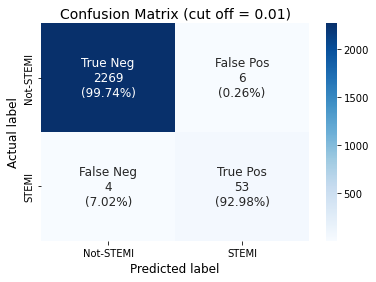

In [34]:
low_uncertainty(sing_entropy_list, y_test, sing_proba, sing_pred, sco_15, sval_yi)

### 5.3.2. Deep Ensembles

Uncertainty High: 17.40%
[[108 324]
 [  1  48]] 

Accuracy 0.3243
Sensitivity 0.9796
Specificity 0.25
PPV 0.129
NPV 0.9908
AUROC 0.8969
Average Precision 0.5197
Precision 0.7778
Recall 0.1429
F1 0.2414


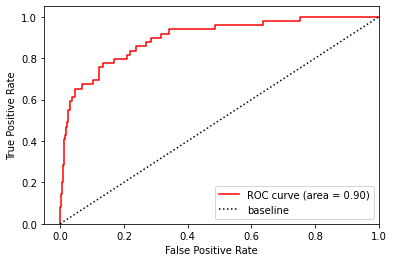

None


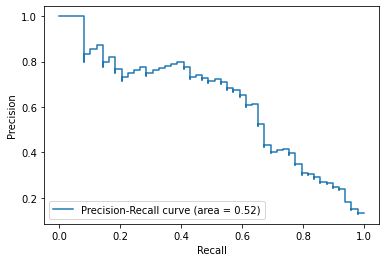

None
None
None


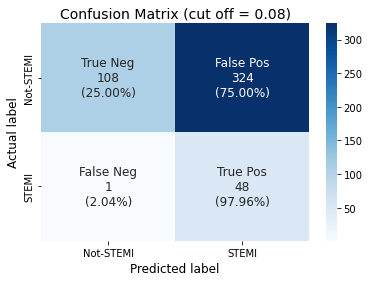

In [35]:
high_uncertainty(de_entropy_list, y_test, de_proba, de_pred, co_15, dval_yi)

Uncertainty Low: 82.60%
[[2227    4]
 [   4   49]] 

Accuracy 0.9965
Sensitivity 0.9245
Specificity 0.9982
PPV 0.9245
NPV 0.9982
AUROC 0.9806
Average Precision 0.9273
Precision 0.9245
Recall 0.9245
F1 0.9245


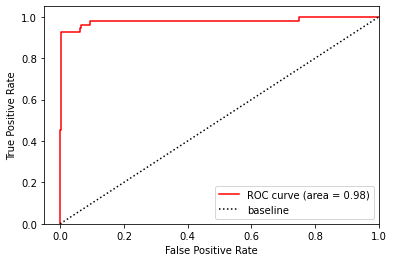

None


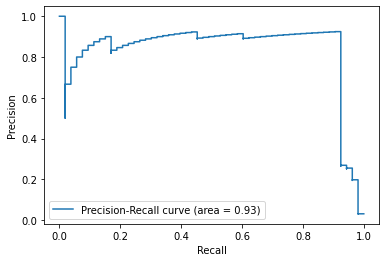

None
None
None


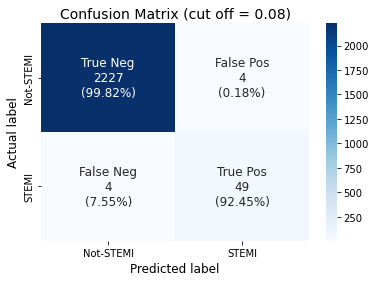

In [36]:
low_uncertainty(de_entropy_list, y_test, de_proba, de_pred, co_15, dval_yi)